In [22]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import deque

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [24]:
class Memory:
    def __init__(self):
        self.batch = deque([],maxlen=2000)
    
    def clear_the_batch(self):
        self.batch = []

    def add_batch(self, sample: tuple):
        self.batch.append(sample)
    
    def get_batch(self):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []

        for state, action, reward, next_state in self.batch:
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
        
        return (torch.tensor(state_batch, device=device), torch.tensor(action_batch, device=device), torch.tensor(reward_batch, device=device), torch.tensor(next_state_batch, device=device))



def t(x): return torch.from_numpy(x).float().to(device)

In [25]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_actions),
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [26]:
# Critic module
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, X):
        return self.model(X)

In [27]:
env = gym.make("CartPole-v1")

In [28]:
# config
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim, n_actions).to(device)
old_actor = Actor(state_dim, n_actions).to(device)
buffer = Memory()
critic = Critic(state_dim).to(device)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=5e-4)

gamma = 0.99
sampling_epoch = 5
epoch = 5
eps = 0.05 

In [29]:
actor_state_dict = actor.state_dict()
old_actor.load_state_dict(actor_state_dict)

<All keys matched successfully>

In [30]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(score_list,show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) 
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

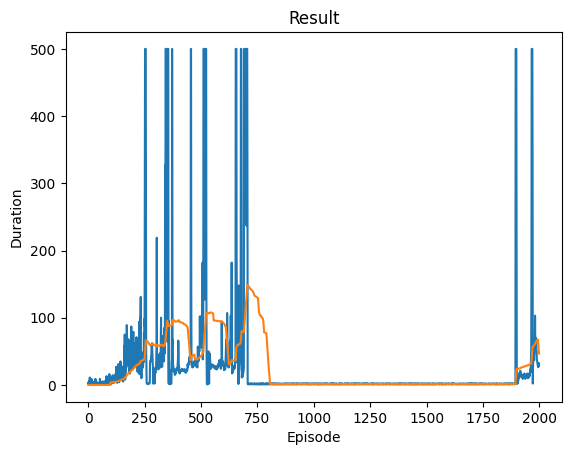

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [31]:
episode_rewards = []
score_list = []

for i in range(2000):
    done = False
    total_reward = 0
    state, _ = env.reset()


    while not done:
        for _ in range(sampling_epoch):
            probs = actor(t(state))

            dist = torch.distributions.Categorical(probs=probs)
            action = dist.sample()
        
            next_state, reward, done, info, _ = env.step(action.detach().data.cpu().numpy())
            
            buffer.add_batch((state, action, reward, next_state)) 
            state = next_state
        
        lmbda = 0.95 
        
        batches = buffer.get_batch() # state, action, reward, next_state
        d_factor = torch.tensor([(lmbda*gamma) ** i for i in range(len(batches[0]))], device=device)

        advantage = (batches[2].view(-1,1) + batches[2].view(-1,1)*gamma*critic(batches[3])).detach() - critic(batches[0])
        for i in range(len(advantage)):
            advantage[i] = sum(advantage[i:])

        for _ in range(epoch):
            theta = actor(batches[0]).gather(1,batches[1].reshape(len(batches[1]),1))
            theta_old = old_actor(batches[0]).gather(1,batches[1].reshape(len(batches[1]),1)).detach()
            ratio = theta/theta_old

            actor_loss = - sum(torch.min(ratio * d_factor.view(-1,1)*advantage.detach(), torch.clamp(ratio, 1-eps, 1+eps) * (d_factor.view(-1,1)*advantage.detach())))

            actor_state_dict = actor.state_dict()
            old_actor.load_state_dict(actor_state_dict)

            adam_actor.zero_grad()
            actor_loss.backward(retain_graph=True)
            adam_actor.step()

            critic_loss = sum(advantage.pow(2))
            adam_critic.zero_grad()
            critic_loss.backward(retain_graph=True)
            adam_critic.step()
            
        buffer.clear_the_batch()
        total_reward += reward
        if total_reward >= 500:
            done = True
        
        if done:
            episode_rewards.append(total_reward)
            plot_durations(episode_rewards)
            break
    env.close()

plot_durations(episode_rewards, show_result=True)
plt.ioff()
plt.show()
  